# Random Forest No Supervisado.  
<b>Implementación:</b> Juan Fernando Hernández Zapata.

## Iris Dataset + PCA 2D

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
y = iris.target

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))

X_reduced = PCA(n_components=2).fit_transform(iris.data)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("First two PCA directions")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")


plt.show()

<Figure size 800x600 with 1 Axes>

## Kmeans

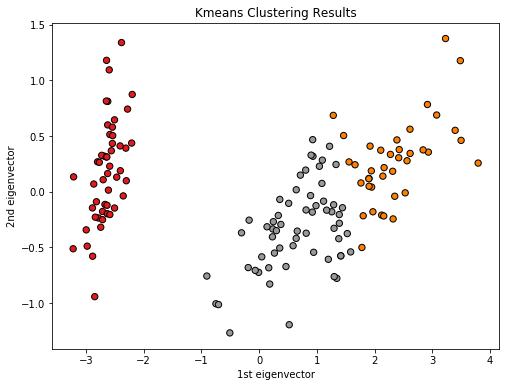

In [2]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_reduced)
X_reduced = PCA(n_components=2).fit_transform(iris.data)

fig = plt.figure(1, figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("Kmeans Clustering Results")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")


plt.show()

# Unsupervised RF

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd


clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(X_reduced, iris.target)  



print(clf.feature_importances_)

#print(clf.predict([[0, 0, 0, 0]]))

[0.70366151 0.29633849]


In [4]:
XPCA = pd.DataFrame(X_reduced)
XPCA['label'] = 0
XPCA.head()

,0,1,label
0,-2.684126,0.319397,0
1,-2.714142,-0.177001,0
2,-2.888991,-0.144949,0
3,-2.745343,-0.318299,0
4,-2.728717,0.326755,0


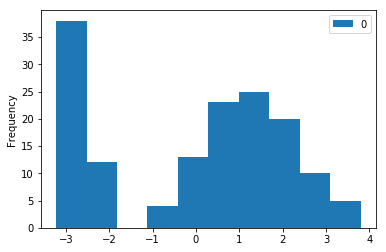

In [5]:
ax = pd.DataFrame(X_reduced).plot(1,kind='hist')

In [6]:
XPCA.std()

0        2.056269
1        0.492616
label    0.000000
dtype: float64

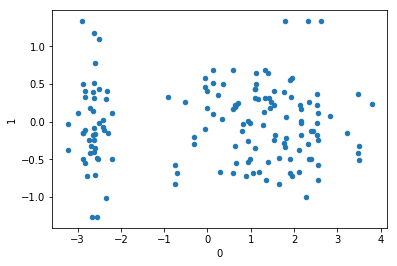

In [7]:
import numpy as np
X_random = [(np.random.choice(XPCA[0].values), np.random.choice(XPCA[1].values) ) for n in range(len(XPCA[0].values))]

X_random_df = pd.DataFrame(X_random)
X_random_df['label'] = 1
ax = X_random_df.plot(0,1, kind='scatter')

In [8]:
X_random_df.std()

0        2.066942
1        0.508404
label    0.000000
dtype: float64

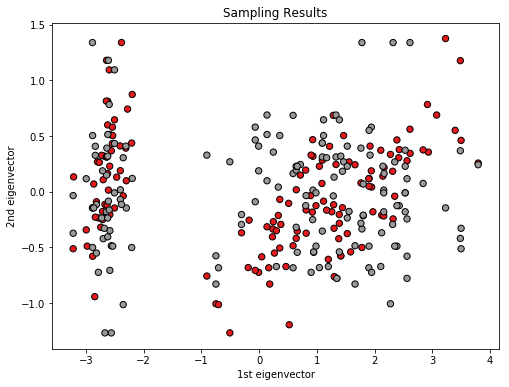

In [9]:
# Uniendo los DataSet
final_df = pd.concat([XPCA, X_random_df], axis=0)

fig = plt.figure(1, figsize=(8, 6))
plt.scatter(final_df[0], final_df[1], c=final_df['label'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("Sampling Results")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")

plt.show()

In [10]:
final_df.columns = ['pca1', 'pca2', 'label']
final_df.index.name = 'index'
final_df.head()

,pca1,pca2,label
index,,,
0,-2.684126,0.319397,0
1,-2.714142,-0.177001,0
2,-2.888991,-0.144949,0
3,-2.745343,-0.318299,0
4,-2.728717,0.326755,0


In [11]:
def proximityMatrix(model, X, normalize=True):      

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat   


In [12]:
from sklearn.ensemble import  RandomForestClassifier
from sklearn.datasets import load_breast_cancer
train = load_breast_cancer()

model = RandomForestClassifier(n_estimators=500, max_features=2, min_samples_leaf=40)
model.fit(final_df[['pca1', 'pca2']], final_df['label'])
D = 1 - proximityMatrix(model, final_df[['pca1', 'pca2']].values, normalize=True)


In [13]:
from pyclustering.cluster.kmedoids import kmedoids

K = 3

np.random.seed(0)
initial_index = np.random.randint(1,len(final_df),size=K)

# create K-Medoids algorithm for processing distance matrix instead of points
kmedoids_instance = kmedoids(D, initial_index, tolerance = 1e-8, data_type='distance_matrix')
# run cluster analysis and obtain results
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

In [14]:
cluster_total = []
for k in range(K):
    
    clusters_df = pd.DataFrame(clusters[k], columns = ['index'])
    clusters_df['k'] = k
    clusters_df.set_index('index')
    
    cluster_total.append(clusters_df)
    
cluster_total_df = pd.concat(cluster_total).set_index('index')
cluster_total_df['k'].value_counts()


2    105
0    100
1     95
Name: k, dtype: int64

In [15]:
cluster_total_df['k'].value_counts()

2    105
0    100
1     95
Name: k, dtype: int64

In [16]:
# Cruza de información 

respuesta_df = pd.merge(final_df, cluster_total_df, how='inner', on='index')
respuesta_df.head()

,pca1,pca2,label,k
index,,,,
0,-2.684126,0.319397,0,1
0,-2.310256,0.409203,1,1
1,-2.714142,-0.177001,0,1
1,2.841673,0.074591,1,1
2,-2.888991,-0.144949,0,1


In [17]:
origen_df = respuesta_df[respuesta_df['label'] == 0]
origen_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 4 columns):
pca1     150 non-null float64
pca2     150 non-null float64
label    150 non-null int64
k        150 non-null int64
dtypes: float64(2), int64(2)
memory usage: 5.9 KB


In [18]:
origen_df['k'].value_counts()

0    57
1    47
2    46
Name: k, dtype: int64

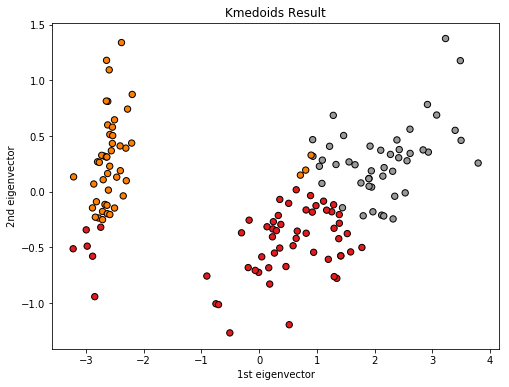

In [19]:


fig = plt.figure(1, figsize=(8, 6))
plt.scatter(origen_df['pca1'], origen_df['pca2'], c=origen_df['k'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("Kmedoids Result")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")

plt.show()

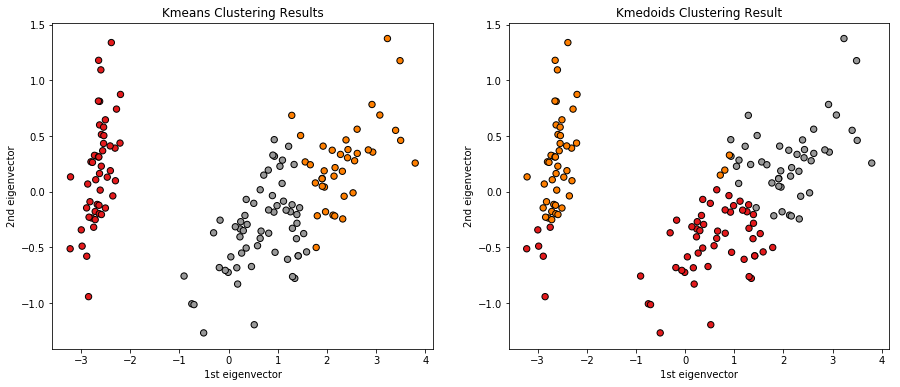

In [20]:
fig = plt.figure(1, figsize=(15, 6))
plt.subplot(1,2,2)
plt.scatter(origen_df['pca1'], origen_df['pca2'], c=origen_df['k'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("Kmedoids Clustering Result")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")

ax2 = plt.subplot(1,2,1)
ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax2.set_title("Kmeans Clustering Results")
ax2.set_xlabel("1st eigenvector")
ax2.set_ylabel("2nd eigenvector")

plt.show()